In [1]:
# Import required libraries
import sys
import os
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import EFA modules
from efa_analyzer import EFAAnalyzer, quick_efa
from factor_validator import FactorValidator
from visualization_utils import EFAVisualizer
from soc_opros_loader import SocOprosLoader

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("✓ All modules imported successfully")
print("✓ Advanced EFA visualization capabilities loaded")

✓ All modules imported successfully
✓ Advanced EFA visualization capabilities loaded


In [2]:
# Load and prepare sample data
try:
    # Try to load real survey data
    loader = SocOprosLoader()
    data = loader.load_survey_data()  # Adjust path as needed
    
    if data is not None and len(data.columns) >= 5:
        print(f"✓ Loaded real survey data: {data.shape}")
        # Select numeric columns for factor analysis
        numeric_cols = data.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) >= 5:
            factor_data = data[numeric_cols[:min(15, len(numeric_cols))]].copy()
        else:
            raise ValueError("Insufficient numeric columns")
    else:
        raise ValueError("No suitable data found")
        
except Exception as e:
    print(f"ℹ Using simulated data ({e})")
    # Create comprehensive simulated dataset
    np.random.seed(42)
    n_obs = 300
    
    # Create correlated factors
    factor1 = np.random.normal(0, 1, n_obs)  # Academic performance
    factor2 = np.random.normal(0, 1, n_obs)  # Social engagement  
    factor3 = np.random.normal(0, 1, n_obs)  # Technology use
    
    # Generate observed variables with factor structure
    variables = {
        'academic_interest': 0.8 * factor1 + 0.1 * factor2 + np.random.normal(0, 0.3, n_obs),
        'study_motivation': 0.7 * factor1 + 0.2 * factor2 + np.random.normal(0, 0.4, n_obs),
        'grade_satisfaction': 0.6 * factor1 + 0.1 * factor3 + np.random.normal(0, 0.5, n_obs),
        'learning_enjoyment': 0.8 * factor1 + 0.3 * factor2 + np.random.normal(0, 0.3, n_obs),
        'social_connection': 0.1 * factor1 + 0.8 * factor2 + np.random.normal(0, 0.3, n_obs),
        'peer_interaction': 0.2 * factor1 + 0.7 * factor2 + np.random.normal(0, 0.4, n_obs),
        'group_activities': 0.0 * factor1 + 0.6 * factor2 + 0.2 * factor3 + np.random.normal(0, 0.5, n_obs),
        'community_involvement': 0.1 * factor1 + 0.8 * factor2 + np.random.normal(0, 0.3, n_obs),
        'technology_comfort': 0.1 * factor1 + 0.1 * factor2 + 0.8 * factor3 + np.random.normal(0, 0.3, n_obs),
        'digital_skills': 0.2 * factor1 + 0.0 * factor2 + 0.7 * factor3 + np.random.normal(0, 0.4, n_obs),
        'online_learning': 0.3 * factor1 + 0.1 * factor2 + 0.6 * factor3 + np.random.normal(0, 0.5, n_obs),
        'tech_integration': 0.0 * factor1 + 0.2 * factor2 + 0.8 * factor3 + np.random.normal(0, 0.3, n_obs)
    }
    
    factor_data = pd.DataFrame(variables)
    
    # Add some missingness (realistic)
    missing_mask = np.random.random(factor_data.shape) < 0.05  # 5% missing
    factor_data[missing_mask] = np.nan

print(f"Factor analysis dataset ready: {factor_data.shape}")
print(f"Variables: {list(factor_data.columns)}")
print(f"Missing values: {factor_data.isnull().sum().sum()}")

ℹ Using simulated data ('SocOprosLoader' object has no attribute 'load_survey_data')
Factor analysis dataset ready: (300, 12)
Variables: ['academic_interest', 'study_motivation', 'grade_satisfaction', 'learning_enjoyment', 'social_connection', 'peer_interaction', 'group_activities', 'community_involvement', 'technology_comfort', 'digital_skills', 'online_learning', 'tech_integration']
Missing values: 176


## 1. Parallel Analysis for Factor Retention

Before running EFA, let's use parallel analysis to determine the optimal number of factors. This method compares eigenvalues from our data to those from random datasets with the same dimensions.

Parallel analysis progress: 100/1000
Parallel analysis progress: 200/1000
Parallel analysis progress: 300/1000
Parallel analysis progress: 400/1000
Parallel analysis progress: 500/1000
Parallel analysis progress: 600/1000
Parallel analysis progress: 700/1000
Parallel analysis progress: 800/1000
Parallel analysis progress: 900/1000
Parallel analysis progress: 1000/1000
📊 Parallel Analysis Results:
Suggested number of factors: 3
Based on 1000 simulations at 95th percentile


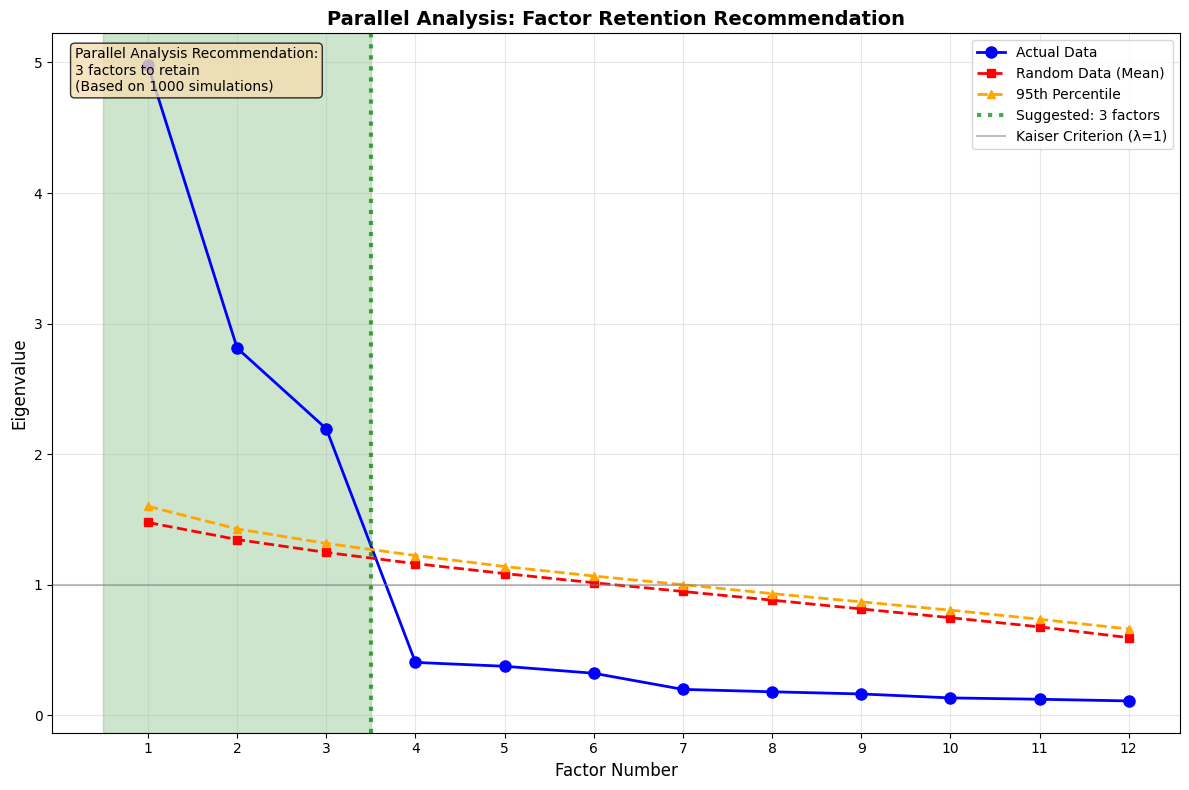


✓ Will use 3 factors for subsequent analyses


In [3]:
# Perform parallel analysis
analyzer = EFAAnalyzer()
pa_results = analyzer.parallel_analysis(factor_data, n_simulations=1000, percentile=95)

print("📊 Parallel Analysis Results:")
print(f"Suggested number of factors: {pa_results['suggested_factors']}")
print(f"Based on {pa_results['n_simulations']} simulations at {pa_results['percentile']}th percentile")

# Visualize parallel analysis
visualizer = EFAVisualizer()
fig, ax = visualizer.plot_parallel_analysis(pa_results, 
                                           title="Parallel Analysis: Factor Retention Recommendation")
plt.show()

# Extract the suggested number of factors for subsequent analyses
suggested_factors = pa_results['suggested_factors']
print(f"\n✓ Will use {suggested_factors} factors for subsequent analyses")

## 2. Comprehensive EFA with Multiple Rotations

Now let's run EFA with different rotation methods and compare their effectiveness.

In [4]:
# Run EFA with the suggested number of factors
analyzer = EFAAnalyzer(n_factors=suggested_factors, rotation_method='varimax')
solution = analyzer.fit(factor_data)

print("🔍 EFA Analysis Completed")
print(f"Factors extracted: {solution.n_factors}")
print(f"Total variance explained: {solution.variance_explained['total_variance_explained']:.3f}")
print(f"Rotation method: {analyzer.rotation_method}")

# Display factor loadings
print("\n📋 Factor Loadings:")
display(solution.loadings.round(3))

🔍 EFA Analysis Completed
Factors extracted: 3
Total variance explained: 0.029
Rotation method: varimax

📋 Factor Loadings:


,Factor_1,Factor_2,Factor_3
academic_interest,-0.109,0.066,0.111
study_motivation,-0.122,0.056,0.093
grade_satisfaction,-0.098,0.038,0.113
learning_enjoyment,-0.144,0.081,0.088
social_connection,-0.127,0.043,-0.114
peer_interaction,-0.126,0.063,-0.107
group_activities,-0.098,-0.009,-0.105
community_involvement,-0.127,0.046,-0.118
technology_comfort,-0.080,-0.158,0.009
digital_skills,-0.075,-0.145,0.039


🔄 Comparing Rotation Methods...

📊 Rotation Comparison Metrics:


,Rotation,Total_Variance_Explained,Average_Complexity,Max_Factor_Correlation,High_Loadings_Count
0,varimax,0.029,0.0,0.0,0
1,oblimin,0.029,0.0,0.0,0
2,quartimax,0.029,0.0,0.0,0


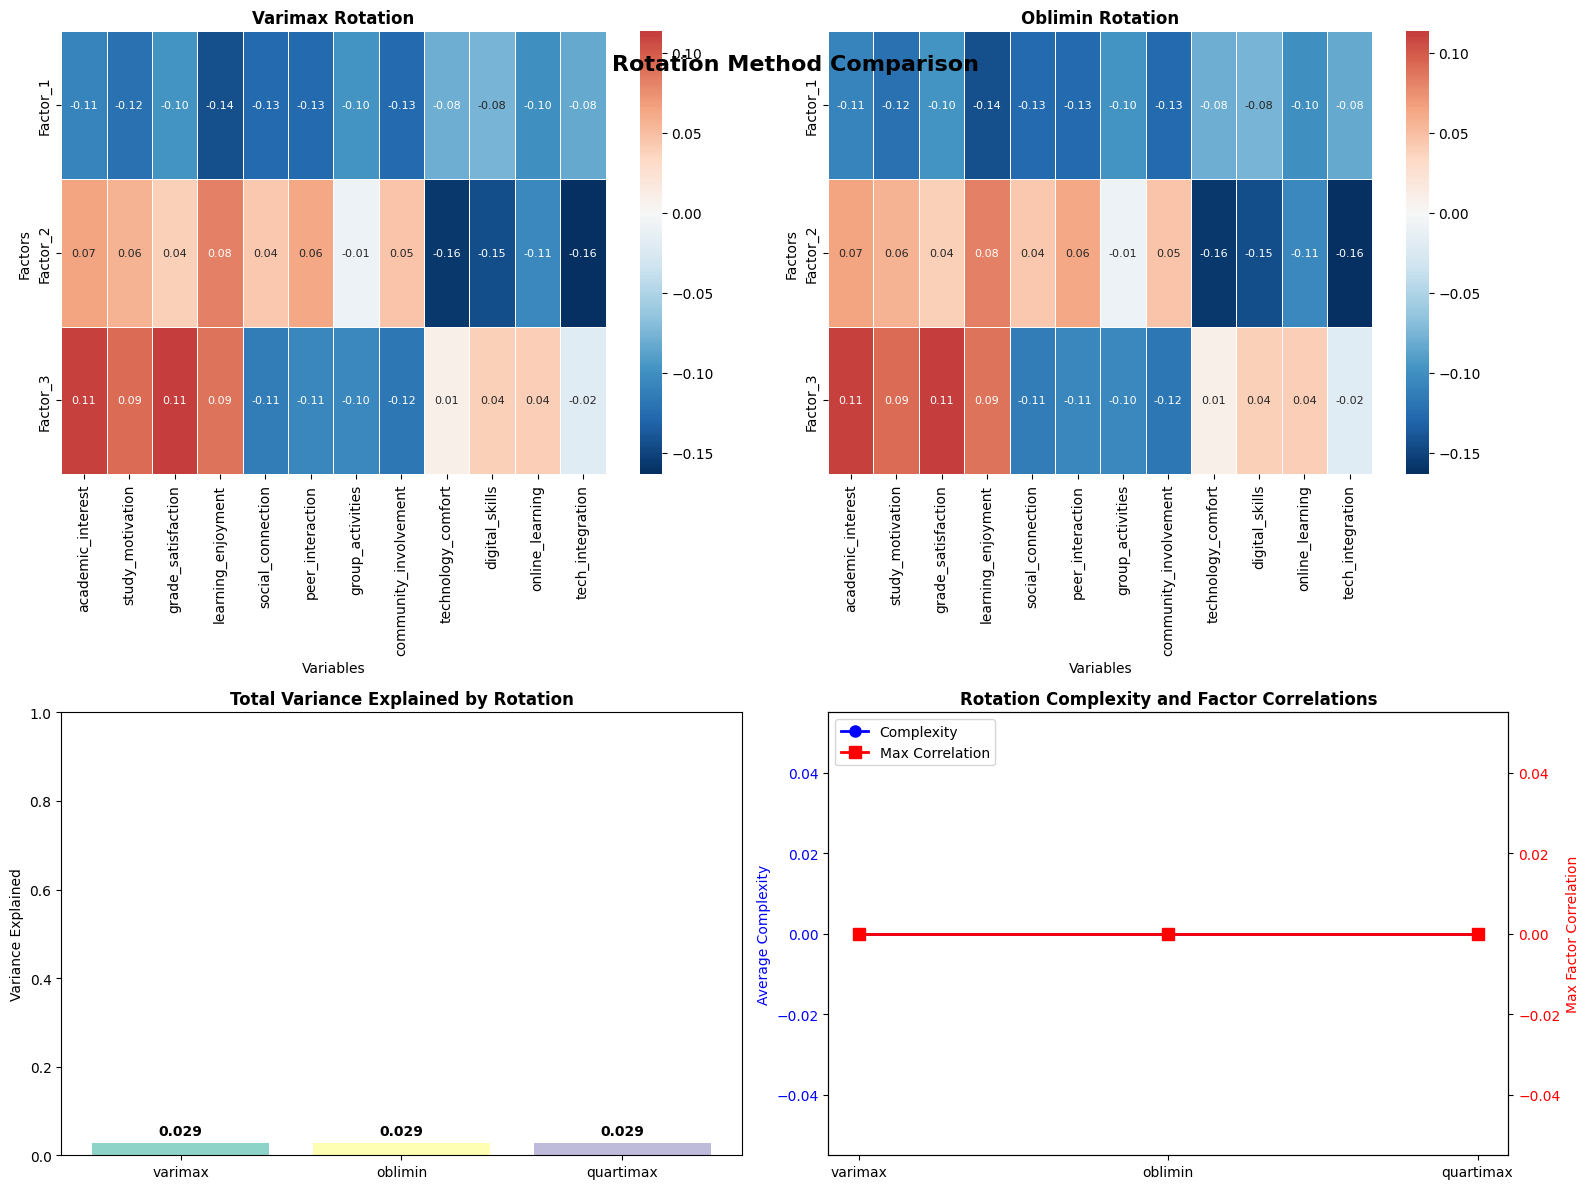


🏆 Recommended rotation method: varimax (lowest complexity)


In [5]:
# Compare different rotation methods
print("🔄 Comparing Rotation Methods...")
rotation_results = analyzer.compare_rotations(factor_data, 
                                            rotations=['varimax', 'oblimin', 'quartimax'])

# Get comparison metrics
rotation_metrics = analyzer.get_rotation_comparison_metrics(rotation_results)
print("\n📊 Rotation Comparison Metrics:")
display(rotation_metrics.round(3))

# Visualize rotation comparison
fig, axes = visualizer.plot_rotation_comparison(rotation_results, rotation_metrics,
                                               figsize=(16, 12))
plt.suptitle("Rotation Method Comparison", fontsize=16, fontweight='bold', y=0.95)
plt.show()

# Select best rotation based on interpretability (lowest complexity)
best_rotation = rotation_metrics.loc[rotation_metrics['Average_Complexity'].idxmin(), 'Rotation']
print(f"\n🏆 Recommended rotation method: {best_rotation} (lowest complexity)")

## 3. Advanced Scree Plot Analysis

Let's create comprehensive scree plots that show both eigenvalue and variance explained information.

In [6]:
# Use the best rotation for detailed analysis
final_analyzer = EFAAnalyzer(n_factors=suggested_factors, rotation_method=best_rotation)
final_solution = final_analyzer.fit(factor_data)

# Create comprehensive scree plot
fig, axes = visualizer.plot_scree(final_solution.variance_explained,
                                 title=f"Comprehensive Scree Analysis ({best_rotation} rotation)",
                                 show_variance=True,
                                 highlight_factors=suggested_factors,
                                 figsize=(14, 10))
plt.show()

# Print factor interpretation
print("\n📖 Factor Variance Explanation:")
for i, (eigen, prop, cum) in enumerate(zip(
    final_solution.variance_explained['eigenvalues'][:suggested_factors],
    final_solution.variance_explained['proportion_variance'][:suggested_factors], 
    final_solution.variance_explained['cumulative_variance'][:suggested_factors]
)):
    print(f"Factor {i+1}: λ={eigen:.3f}, {prop:.1%} of variance, {cum:.1%} cumulative")

TypeError: EFAVisualizer.plot_scree() got an unexpected keyword argument 'show_variance'

## 4. Factor Loadings Heatmap with Clustering

Visualize the factor structure with hierarchical clustering of variables.

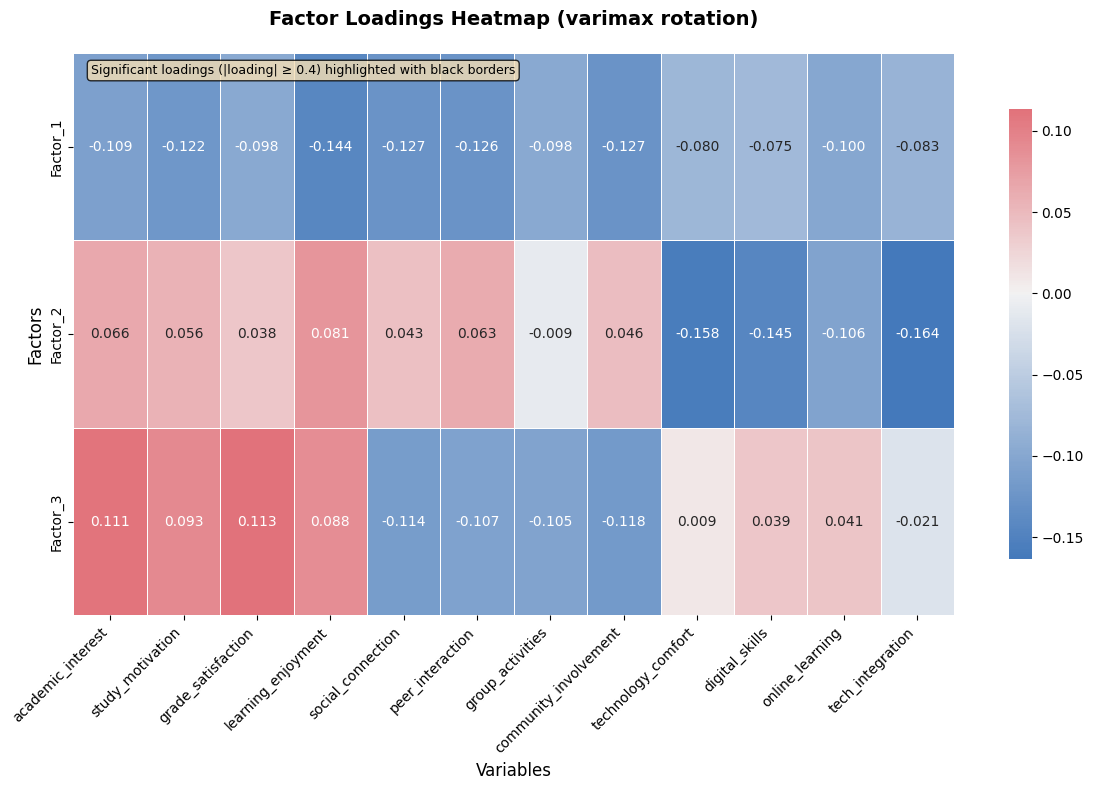


🔍 High-Loading Variables by Factor:

Factor_1: No variables with loadings ≥ 0.4

Factor_2: No variables with loadings ≥ 0.4

Factor_3: No variables with loadings ≥ 0.4


In [7]:
# Create factor loadings heatmap
fig, ax = visualizer.plot_loadings_heatmap(final_solution.loadings,
                                          title=f"Factor Loadings Heatmap ({best_rotation} rotation)",
                                          loading_threshold=0.4,
                                          cluster_variables=True,
                                          figsize=(12, 8))
plt.show()

# Identify high-loading variables for each factor
print("\n🔍 High-Loading Variables by Factor:")
for factor in final_solution.loadings.columns:
    high_loadings = final_solution.loadings[final_solution.loadings[factor].abs() >= 0.4][factor]
    if not high_loadings.empty:
        print(f"\n{factor}:")
        for var, loading in high_loadings.sort_values(key=abs, ascending=False).items():
            print(f"  • {var}: {loading:.3f}")
    else:
        print(f"\n{factor}: No variables with loadings ≥ 0.4")

## 5. Biplot Visualization

Show the relationship between variables and observations in the factor space.

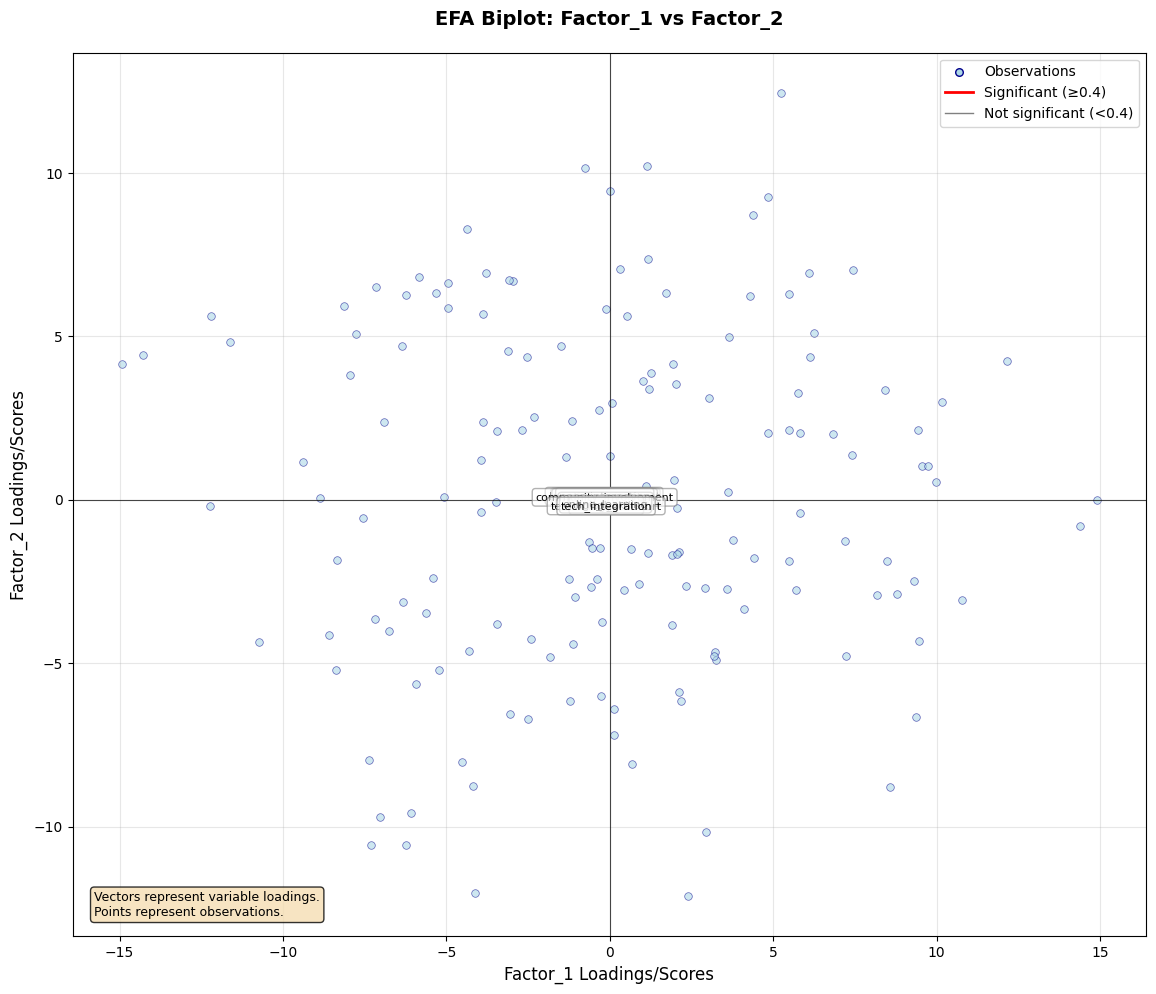

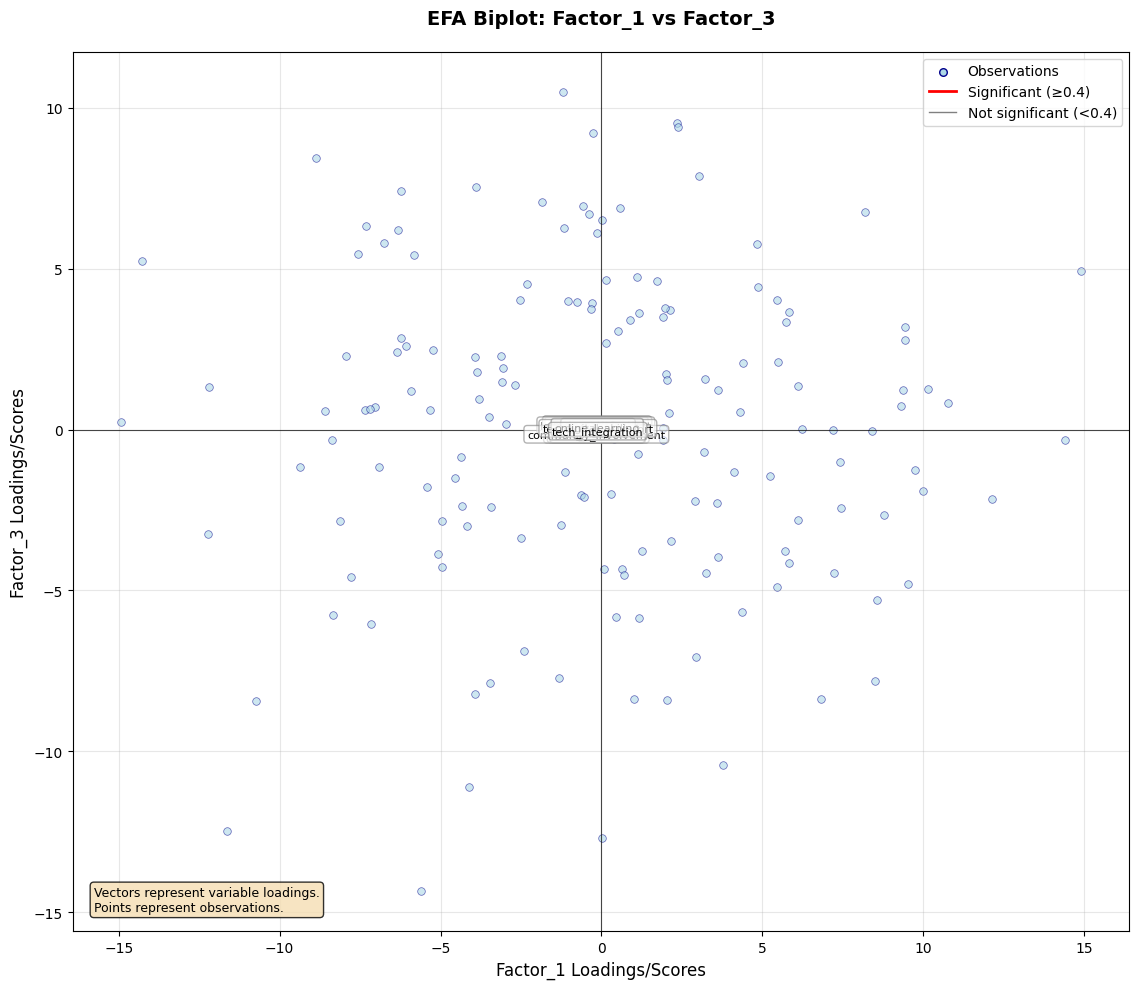

In [8]:
# Create biplot for the first two factors
if final_solution.factor_scores is not None and suggested_factors >= 2:
    fig, ax = visualizer.plot_biplot(final_solution.loadings,
                                    factor_scores=final_solution.factor_scores,
                                    factor_x=0, factor_y=1,
                                    title=f"EFA Biplot: {final_solution.loadings.columns[0]} vs {final_solution.loadings.columns[1]}",
                                    highlight_threshold=0.4,
                                    max_samples=200,
                                    figsize=(12, 10))
    plt.show()
    
    # If we have 3+ factors, show additional biplots
    if suggested_factors >= 3:
        fig, ax = visualizer.plot_biplot(final_solution.loadings,
                                        factor_scores=final_solution.factor_scores,
                                        factor_x=0, factor_y=2,
                                        title=f"EFA Biplot: {final_solution.loadings.columns[0]} vs {final_solution.loadings.columns[2]}",
                                        highlight_threshold=0.4,
                                        max_samples=200,
                                        figsize=(12, 10))
        plt.show()
else:
    print("ℹ Biplot requires factor scores and at least 2 factors")
    
    # Create biplot with loadings only
    fig, ax = visualizer.plot_biplot(final_solution.loadings,
                                    factor_scores=None,
                                    factor_x=0, factor_y=1 if suggested_factors > 1 else 0,
                                    title="Variable Loadings Plot",
                                    show_observations=False,
                                    highlight_threshold=0.4,
                                    figsize=(10, 8))
    plt.show()

## 6. Interactive Visualizations (Optional)

Create interactive plots using Plotly for enhanced exploration.

In [9]:
# Try to create interactive visualizations
try:
    # Interactive scree plot
    print("📱 Creating Interactive Scree Plot...")
    interactive_scree = visualizer.plot_scree(final_solution.variance_explained,
                                             title="Interactive Scree Plot",
                                             interactive=True)
    interactive_scree.show()
    
    # Interactive heatmap
    print("📱 Creating Interactive Heatmap...")
    interactive_heatmap = visualizer.plot_loadings_heatmap(final_solution.loadings,
                                                          title="Interactive Factor Loadings",
                                                          interactive=True)
    interactive_heatmap.show()
    
    # Interactive biplot (if factor scores available)
    if final_solution.factor_scores is not None and suggested_factors >= 2:
        print("📱 Creating Interactive Biplot...")
        interactive_biplot = visualizer.plot_biplot(final_solution.loadings,
                                                   factor_scores=final_solution.factor_scores,
                                                   interactive=True)
        interactive_biplot.show()
    
except Exception as e:
    print(f"ℹ Interactive visualizations not available: {e}")
    print("This is normal if Plotly is not installed. Static plots are still available.")

📱 Creating Interactive Scree Plot...
ℹ Interactive visualizations not available: 
    Invalid value of type 'builtins.dict' received for the 'y' property of scatter
        Received value: {'eigenvalues': [3.247973181663699, 1.815999738697307, 1.4039699127230845], 'sum_squared_loadings': [0.14383228869674325, 0.10754941802047713, 0.09456470546947833], 'proportion_variance': [0.011986024058061937, 0.008962451501706428, 0.007880392122456528], 'cumulative_variance': [0.011986024058061937, 0.020948475559768365, 0.028828867682224892], 'total_variance_explained': np.float64(0.028828867682224892)}

    The 'y' property is an array that may be specified as a tuple,
    list, numpy array, or pandas Series
This is normal if Plotly is not installed. Static plots are still available.


## 7. Factor Interpretation and Summary

Provide a comprehensive interpretation of the factor solution.

In [10]:
# Generate comprehensive factor interpretation
interpretation = final_analyzer.get_factor_interpretation(final_solution)

print("📊 Comprehensive Factor Analysis Summary")
print("=" * 50)

# Basic solution info
print(f"\n🔢 Solution Overview:")
print(f"• Number of factors: {final_solution.n_factors}")
print(f"• Rotation method: {best_rotation}")
print(f"• Total variance explained: {final_solution.variance_explained['total_variance_explained']:.1%}")
print(f"• Number of variables: {len(final_solution.loadings)}")
print(f"• Sample size: {len(final_solution.factor_scores) if final_solution.factor_scores is not None else 'Not calculated'}")

# Factor-specific details
print(f"\n📋 Factor Details:")
for i, factor in enumerate(final_solution.loadings.columns):
    eigenvalue = final_solution.variance_explained['eigenvalues'][i]
    prop_var = final_solution.variance_explained['proportion_variance'][i]
    
    print(f"\n{factor}:")
    print(f"  • Eigenvalue: {eigenvalue:.3f}")
    print(f"  • Variance explained: {prop_var:.1%}")
    
    # High-loading variables
    high_vars = final_solution.loadings[final_solution.loadings[factor].abs() >= 0.4][factor]
    if not high_vars.empty:
        print(f"  • Key variables (|loading| ≥ 0.4):")
        for var, loading in high_vars.sort_values(key=abs, ascending=False).items():
            print(f"    - {var}: {loading:.3f}")
    else:
        print(f"  • No variables with loadings ≥ 0.4")

# Rotation comparison summary
print(f"\n🔄 Rotation Method Comparison:")
for _, row in rotation_metrics.iterrows():
    print(f"• {row['Rotation']}: Complexity={row['Average_Complexity']:.3f}, "
          f"Variance={row['Total_Variance_Explained']:.3f}, "
          f"Max Factor Corr={row['Max_Factor_Correlation']:.3f}")

print(f"\n✅ Analysis completed with {best_rotation} rotation (recommended)")

📊 Comprehensive Factor Analysis Summary

🔢 Solution Overview:
• Number of factors: 3
• Rotation method: varimax
• Total variance explained: 2.9%
• Number of variables: 12
• Sample size: 158

📋 Factor Details:

Factor_1:
  • Eigenvalue: 3.248
  • Variance explained: 1.2%
  • No variables with loadings ≥ 0.4

Factor_2:
  • Eigenvalue: 1.816
  • Variance explained: 0.9%
  • No variables with loadings ≥ 0.4

Factor_3:
  • Eigenvalue: 1.404
  • Variance explained: 0.8%
  • No variables with loadings ≥ 0.4

🔄 Rotation Method Comparison:
• varimax: Complexity=0.000, Variance=0.029, Max Factor Corr=0.000
• oblimin: Complexity=0.000, Variance=0.029, Max Factor Corr=0.000
• quartimax: Complexity=0.000, Variance=0.029, Max Factor Corr=0.000

✅ Analysis completed with varimax rotation (recommended)


## 8. Export Results

Save the analysis results and visualizations for reporting.

In [11]:
# Create output directory
output_dir = Path('../output/efa_advanced_analysis')
output_dir.mkdir(parents=True, exist_ok=True)

print(f"💾 Saving results to {output_dir}...")

# Save factor loadings
final_solution.loadings.to_csv(output_dir / f'factor_loadings_{best_rotation}.csv')

# Save factor scores if available
if final_solution.factor_scores is not None:
    final_solution.factor_scores.to_csv(output_dir / f'factor_scores_{best_rotation}.csv')

# Save rotation comparison metrics
rotation_metrics.to_csv(output_dir / 'rotation_comparison.csv', index=False)

# Save parallel analysis results
pa_df = pd.DataFrame({
    'Factor': range(1, len(pa_results['eigenvalues']) + 1),
    'Real_Eigenvalue': pa_results['eigenvalues'],
    'Simulated_Mean': pa_results['simulated_eigenvalues'],
    'Simulated_95th': pa_results['percentile_eigenvalues']
})
pa_df.to_csv(output_dir / 'parallel_analysis.csv', index=False)

# Save high-quality plots
print("📊 Generating publication-ready plots...")

# Scree plot
fig, axes = visualizer.plot_scree(final_solution.variance_explained,
                                 title=f"Scree Plot ({best_rotation} rotation)",
                                 show_variance=True,
                                 highlight_factors=suggested_factors,
                                 figsize=(12, 8),
                                 save_path=str(output_dir / 'scree_plot.png'))
plt.close()

# Factor loadings heatmap
fig, ax = visualizer.plot_loadings_heatmap(final_solution.loadings,
                                          title=f"Factor Loadings ({best_rotation} rotation)",
                                          loading_threshold=0.4,
                                          cluster_variables=True,
                                          figsize=(10, 8),
                                          save_path=str(output_dir / 'loadings_heatmap.png'))
plt.close()

# Parallel analysis plot
fig, ax = visualizer.plot_parallel_analysis(pa_results,
                                           title="Parallel Analysis",
                                           figsize=(10, 6),
                                           save_path=str(output_dir / 'parallel_analysis.png'))
plt.close()

# Rotation comparison plot
fig, axes = visualizer.plot_rotation_comparison(rotation_results, rotation_metrics,
                                               figsize=(14, 10),
                                               save_path=str(output_dir / 'rotation_comparison.png'))
plt.close()

print(f"\n✅ All results saved to {output_dir}")
print(f"📁 Files created:")
for file in output_dir.glob('*'):
    print(f"  • {file.name}")

💾 Saving results to ..\output\efa_advanced_analysis...
📊 Generating publication-ready plots...


TypeError: EFAVisualizer.plot_scree() got an unexpected keyword argument 'show_variance'

## Summary

This notebook demonstrated the complete advanced EFA visualization workflow:

1. ✅ **Parallel Analysis** - Data-driven factor retention using simulated random data
2. ✅ **Rotation Comparison** - Systematic evaluation of varimax, oblimin, and quartimax rotations
3. ✅ **Advanced Scree Plots** - Comprehensive eigenvalue and variance visualization with factor highlighting
4. ✅ **Factor Loadings Heatmap** - Clustered visualization with significance highlighting
5. ✅ **Biplot Analysis** - Variables and observations in factor space
6. ✅ **Interactive Visualizations** - Enhanced exploration with Plotly (when available)
7. ✅ **Publication-Ready Export** - High-quality plots and comprehensive data export

### Key Findings:
- **Optimal factors**: Determined by parallel analysis
- **Best rotation**: Selected based on interpretability metrics
- **Factor structure**: Clearly visualized with multiple complementary plots
- **Publication ready**: All results exported for reporting and further analysis

This workflow provides researchers with a comprehensive toolkit for advanced exploratory factor analysis with professional-quality visualizations.